---
title: Spectral Analysis
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
import mosek

The library "mosek" above is a commercial solver for convex optimization. I will use "solver = MOSEK" in the convex optimization schemes below for computing the spectral estimators. Mosek is more reliable than the other solvers that cvxpy uses. To use MOSEK, you first have to install it in your python environment (e.g., using "pip install mosek" or "conda install -c conda-forge mosek"), then you need to request a personal mosek academic license (at this address: https://www.mosek.com/products/academic-licenses/ by using your email address). The license will be emailed to you. You need to download the license file and place it in the correct directory (this information is given in the license email). After this, the mosek solver should work in cvxpy. 

## Spectrum Model

We are working with the model: $\text{Re}(b_j), \text{Im}(b_j) \overset{\text{i.i.d}}{\sim} N(0, \gamma_j^2)$ for $j = 1, \dots, m$ (here $m = (n-1)/2$), where $b_0, \dots, b_{n-1}$ denote the DFT of the observed data $y_t$. The parameters underlying this model are $\gamma_1^2, \dots, \gamma_m^2$. The model can be written in terms of the periodogram $I(j/n)$ as
\begin{equation*}
   I(j/n) = \frac{|b_j|^2}{n} \overset{\text{ind}}{\sim} \frac{\gamma_j^2}{n} \chi^2_2
\end{equation*}
The mean of the periodogram is called the power spectrum and is given by
\begin{equation*}
   f(j/n) = \frac{2 \gamma_j^2}{n} ~~~ \text{ for } j = 1, \dots, m. 
\end{equation*}
If we treat $f(j/n)$ as a function on $[0, 1/2]$ (say by joining successive values by lines), we obtain the power spectral density function.

### Application One: Sunspots Dataset



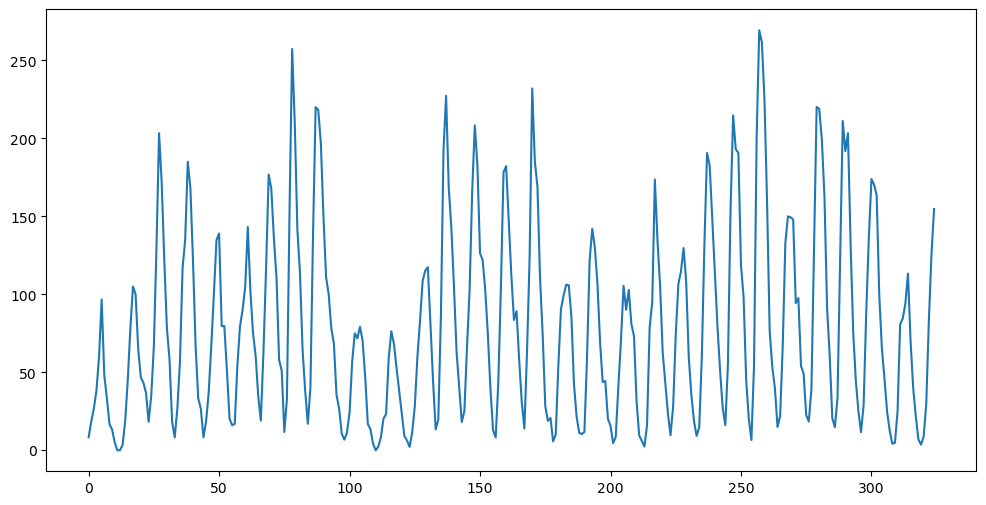

In [78]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

In [79]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

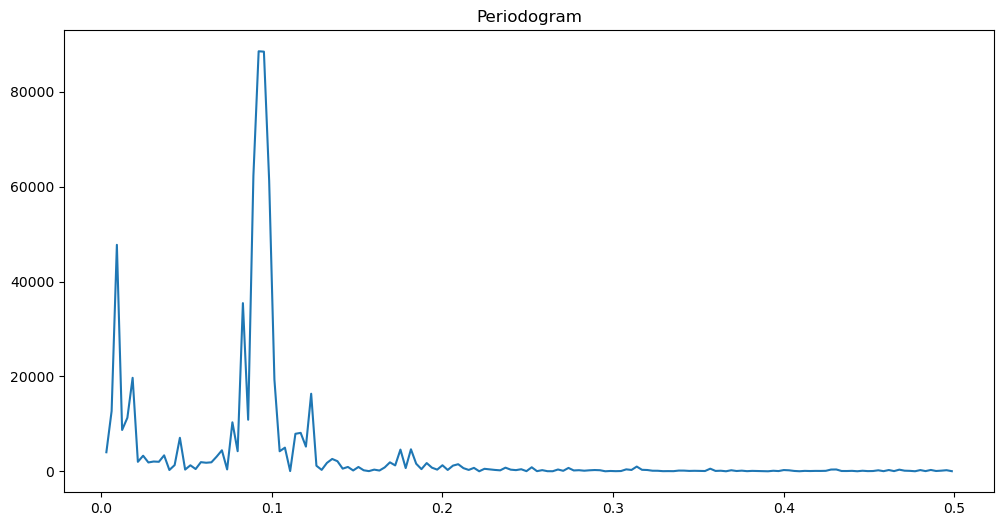

In [80]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram)
plt.title('Periodogram')
plt.show()

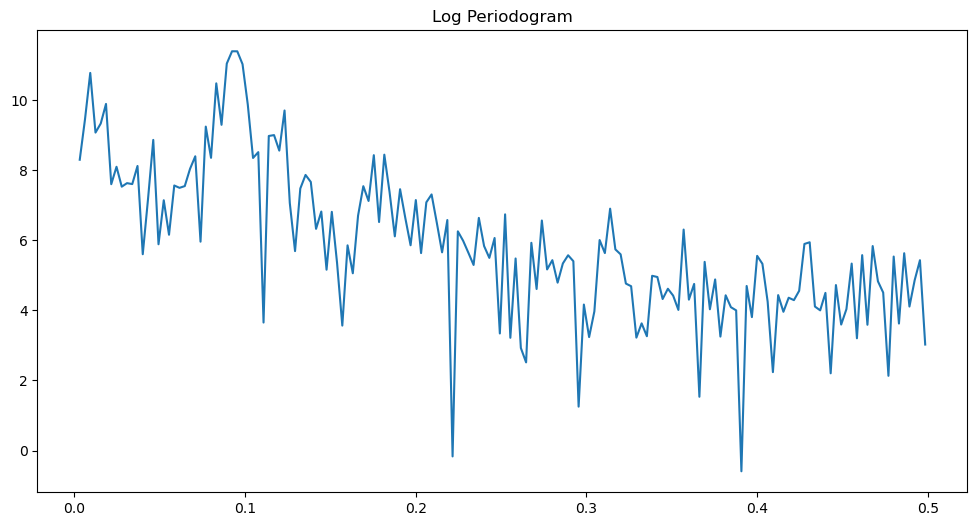

In [81]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram))
plt.title('Log Periodogram')
plt.show()

To estimate $\gamma_j, j = 1, \dots, m$, we use the following estimators (below $\alpha_j = \log \gamma_j$)
\begin{equation*}
   \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)  + \lambda \sum_{j=2}^{m-1} \left((\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right)^2
\end{equation*}
or
\begin{equation*}
    \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right) + \lambda \sum_{j=2}^{m-1} \left|(\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right|.
\end{equation*}

In [82]:
def spectrum_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

The power spectrum is given by 
\begin{equation*}
   f(j/n) = \mathbb{E} I(j/n) = \frac{2 \gamma_j^2}{n} = \frac{2}{n} e^{2 \alpha_j}
\end{equation*}

/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


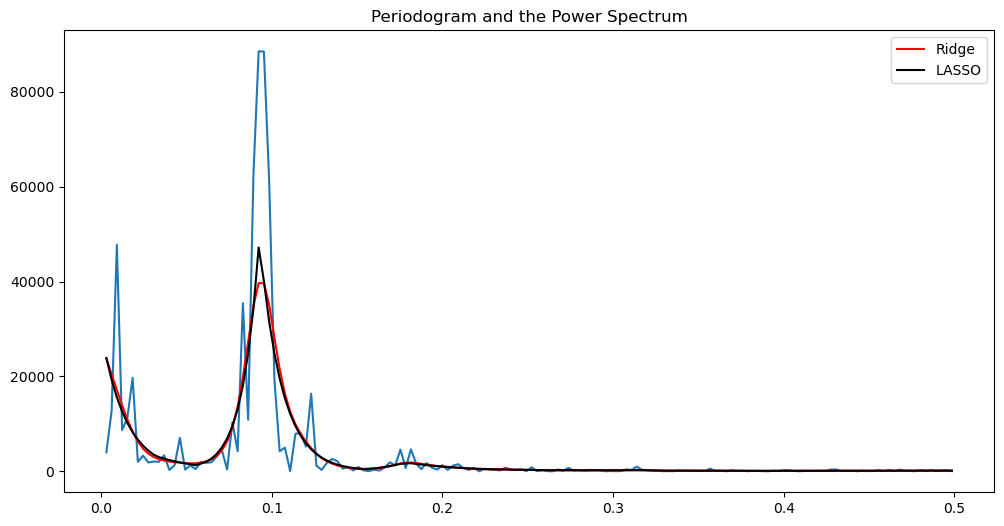

In [ ]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 100)
power_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 10)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, pgram)
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, power_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, power_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()

#Mosek sometimes gives some format conversion warnings which you can ignore

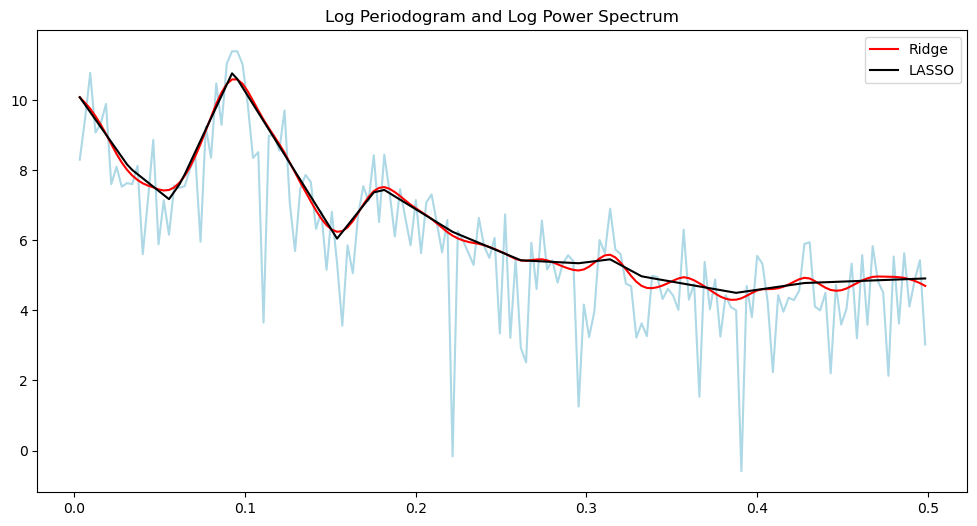

In [84]:
plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, np.log(pgram), linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Log Periodogram and Log Power Spectrum')
plt.plot(freq, np.log(power_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()


There is a whole band of frequencies which contribute towards the mode in the power spectrum. 

### Application Two: Southern Oscillation Index Dataset

This dataset can be downloaded from http://www.bom.gov.au/climate/enso/soi/. El Niño (see wiki entry) is a climate pattern that describes the unusual warming of surface waters in the eastern tropical Pacific Ocean. It is believed to occur irregularly at two to seven year intervals. Closely related to the fluctuations in oceanic temperatures are large-scale changes in atmospheric pressure. El Nino events are associated with sustained negative Southern Oscillation Index (SOI) values. The SOI is computed from fluctuations in the surface air pressure difference between Tahiti and Darwin. See the paper "The definition of El Nino" by Trenberth 1997 for more details. 

Wikipedia article for El Niño Southern Oscillation has this sentence: "El Niño and Li Niña last a year or so and typically occur every two to seven years with varying intensity, with neutral periods of lower intensity interspersed."

In [85]:
def load_soi_data(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip blank lines if any
            
            date_str, soi_str = line.split(',')
            date_code = int(date_str)   # e.g. 187601
            year = date_code // 100     # e.g. 1876
            month = date_code % 100     # e.g. 1
            soi_val = float(soi_str)
            
            data.append([year, month, soi_val])
    
    # Create a DataFrame from parsed rows
    df = pd.DataFrame(data, columns=['Year', 'Month', 'SOI'])
    
    # Convert Year, Month to a datetime; assume day=1 for each month
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    
    # Make Date the index
    df.set_index('Date', inplace=True)
    
    # Sort by date just in case (and drop the now-redundant Year/Month columns)
    df.sort_index(inplace=True)
    
    return df[['SOI']]

# Usage
df_soi = load_soi_data("soi_monthly.txt")
print(df_soi)

             SOI
Date            
1876-01-01  11.3
1876-02-01  11.0
1876-03-01   0.2
1876-04-01   9.4
1876-05-01   6.8
...          ...
2024-10-01   4.2
2024-11-01   6.5
2024-12-01  10.8
2025-01-01   3.7
2025-02-01   3.0

[1790 rows x 1 columns]


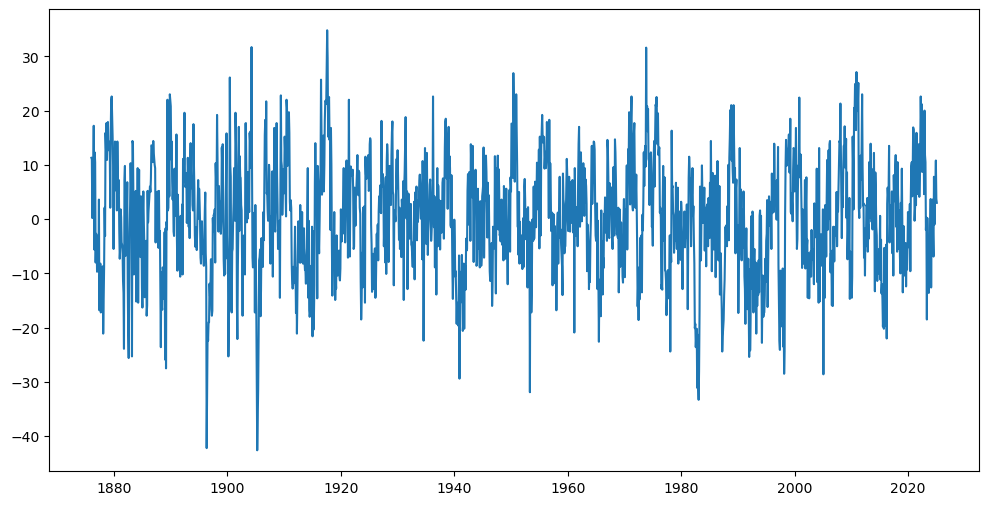

In [86]:
y = df_soi['SOI']
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

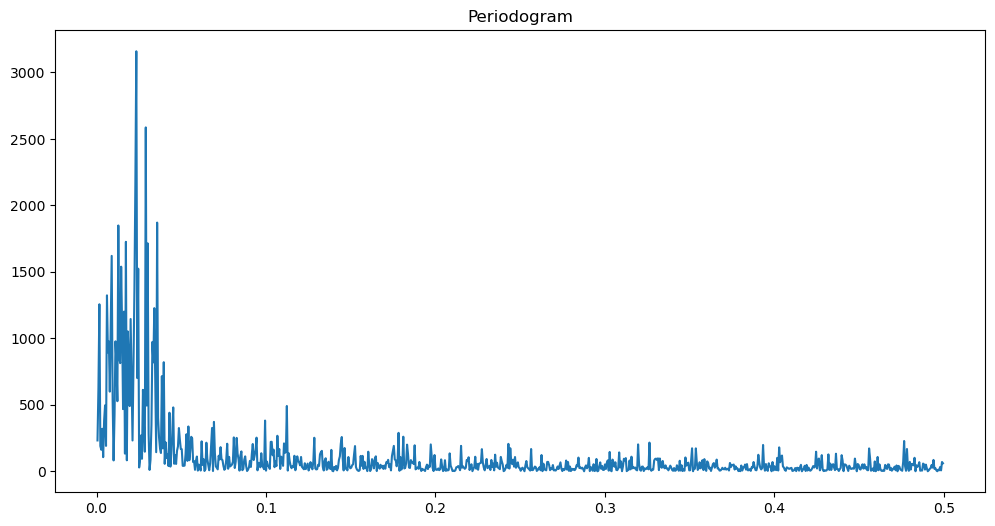

In [87]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram)
plt.title('Periodogram')
plt.show()

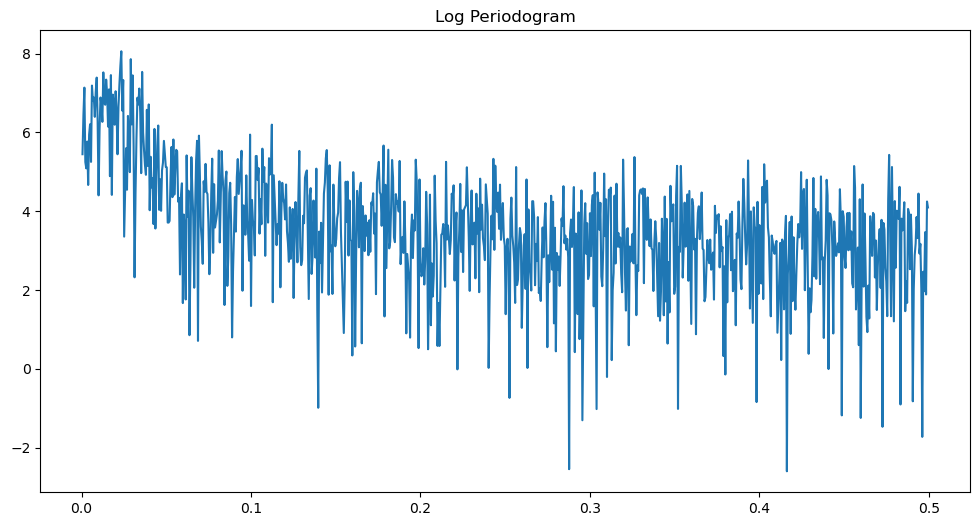

In [88]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram))
plt.title('Log Periodogram')
plt.show()

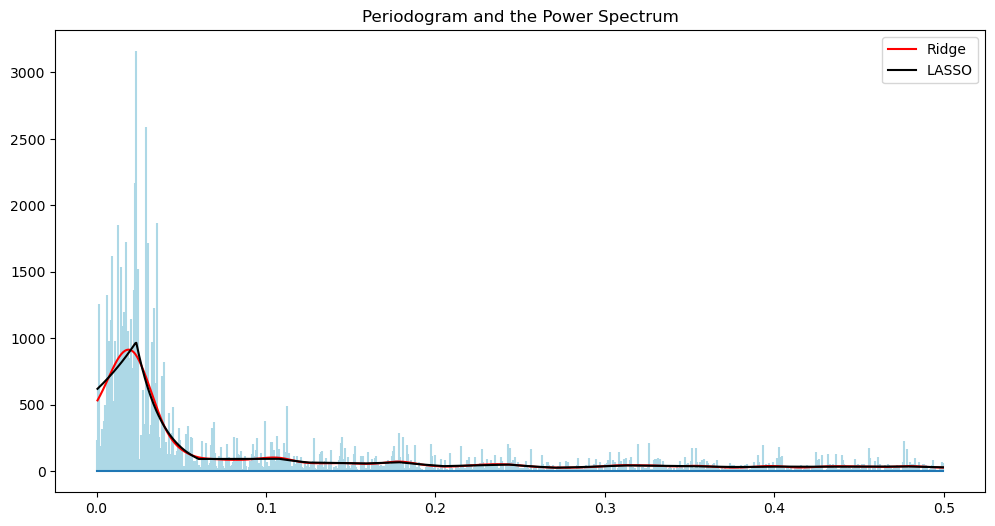

In [96]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 50000)
power_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 100)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
markerline.set_marker("None")
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, power_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, power_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()


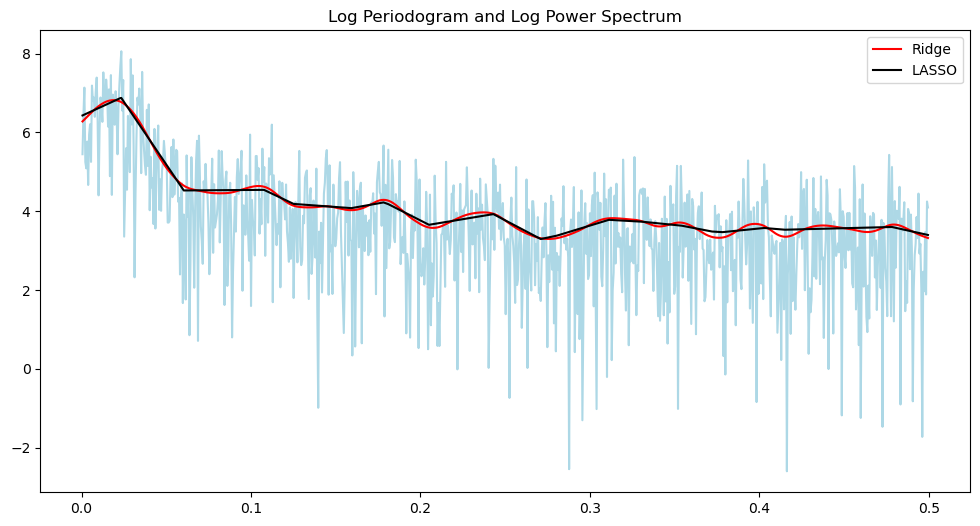

In [97]:
plt.figure(figsize = (12, 6))
#markerline, stemline, baseline = plt.stem(freq, np.log(pgram), linefmt = 'lightblue', basefmt = '')
#markerline.set_marker("None")
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Log Periodogram and Log Power Spectrum')
plt.plot(freq, np.log(power_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()


In [91]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(power_ridge))
print("Peaks:", peaks)
print(1/freq[peaks])

Peaks: [ 33 186 257 318 423 560 631 710 782 857]
[52.64705882  9.57219251  6.9379845   5.61128527  4.22169811  3.19073084
  2.83227848  2.51758087  2.28607918  2.08624709]


The peak therefore corresponds to the period of about 52.64 months, which is about 4.5 years. 

### Application Three: Quake Vibration Dataset

This dataset is from the Mathworks (MATLAB) tutorial "Practical Introduction to Frequency-Domain Analysis" (see [this link](https://www.mathworks.com/help/signal/ug/practical-introduction-to-frequency-domain-analysis.html)). From this matlab tutorial: *Active Mass Driver (AMD) control systems are used to reduce vibration in a building under an earthquake. An active mass driver is placed on the top floor of the building and, based on displacement and acceleration measurements of the building floors, a control system sends signals to the driver so that the mass moves to attenuate ground disturbances. Acceleration measurements were recorded on the first floor of a three story test structure under earthquake conditions. Measurements were taken without the active mass driver control system (open loop condition), and with the active control system (closed loop condition).*

In [98]:
from scipy.io import loadmat
mat_dict = loadmat('quakevibration.mat')
print(mat_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'gfloor1OL', 'gfloor1CL'])


In [99]:
gfloor1OL_array = mat_dict['gfloor1OL']
gfloor1CL_array = mat_dict['gfloor1CL']
print(gfloor1OL_array.shape)
print(gfloor1CL_array.shape)

(10000, 1)
(10000, 1)


In [100]:
y_ol = gfloor1OL_array.ravel()
y_cl = gfloor1CL_array.ravel()

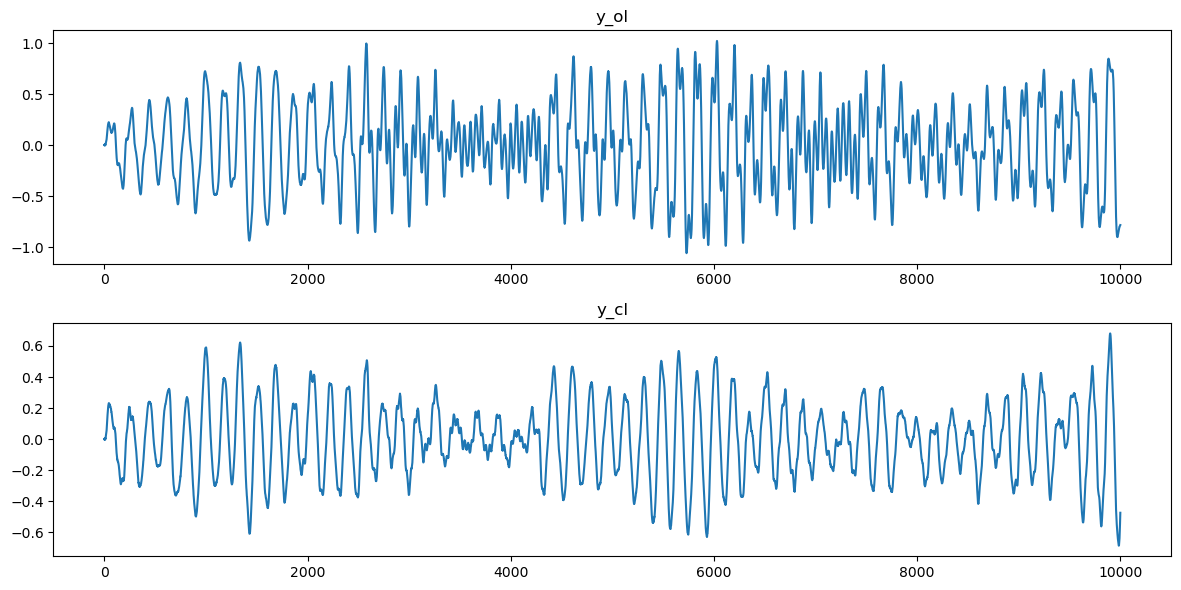

In [101]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

axes[0].plot(y_ol)
axes[0].set_title('y_ol')

axes[1].plot(y_cl)
axes[1].set_title('y_cl')

plt.tight_layout()
plt.show()

In [102]:
n = len(y_ol)
freqs, pgram_ol = periodogram(y_ol)
alpha_opt_ridge_ol, freq = spectrum_estimator_ridge(y_ol, 100000)
pgram_mean_ridge_ol = (2/n)*(np.exp(2*alpha_opt_ridge_ol))
alpha_opt_lasso_ol, freq = spectrum_estimator_lasso(y_ol, 1000)
pgram_mean_lasso_ol = (2/n)*(np.exp(2*alpha_opt_lasso_ol))

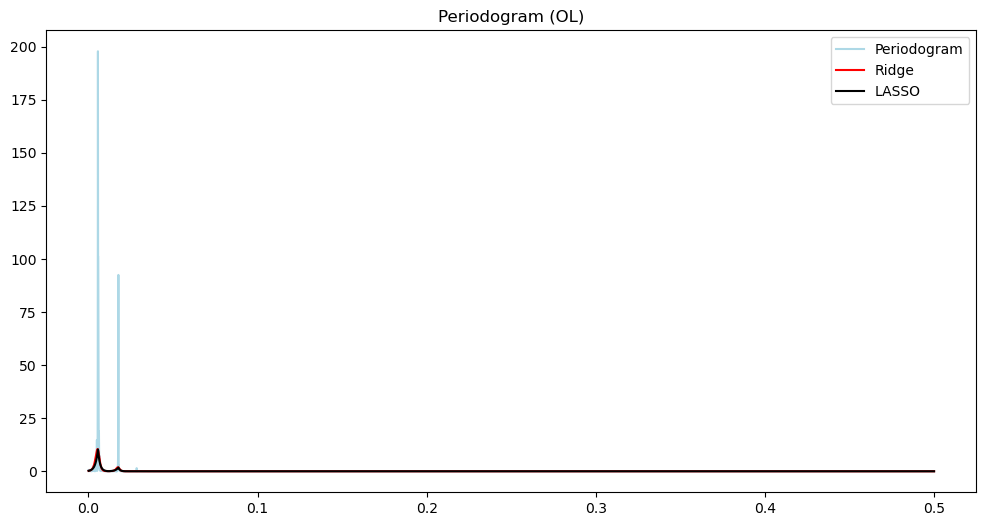

In [103]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, (pgram_ol), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_ol), color = 'None', label = 'Periodogram')
plt.title('Periodogram (OL)')
plt.plot(freqs, (pgram_mean_ridge_ol), color = 'red', label = 'Ridge')
plt.plot(freqs, (pgram_mean_lasso_ol), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

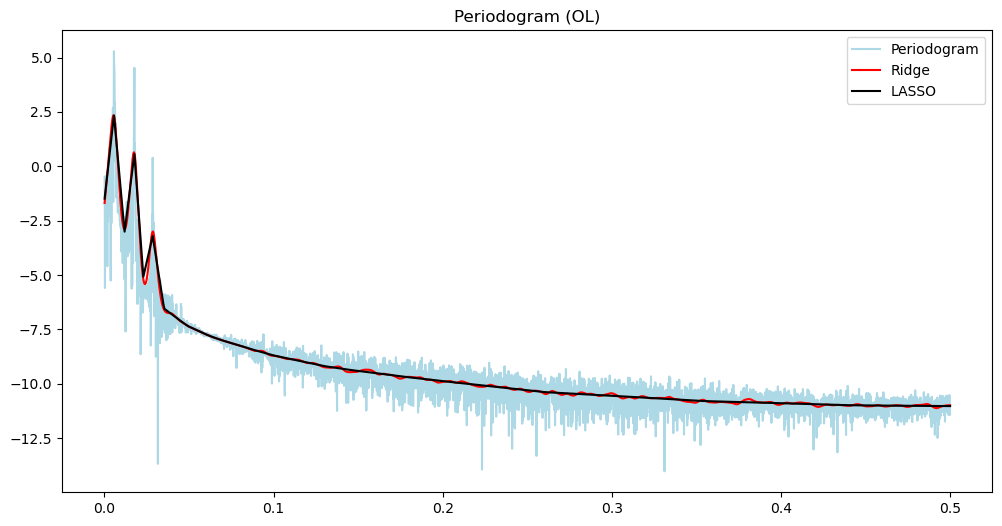

In [104]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_ol), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_ol), color = 'None', label = 'Periodogram')
plt.title('Periodogram (OL)')
plt.plot(freqs, np.log(pgram_mean_ridge_ol), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_ol), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

In [105]:
n = len(y_cl)
freqs, pgram_cl = periodogram(y_cl)
alpha_opt_ridge_cl, freq = spectrum_estimator_ridge(y_cl, 100000)
pgram_mean_ridge_cl = (2/n)*(np.exp(2*alpha_opt_ridge_cl))
alpha_opt_lasso_cl, freq = spectrum_estimator_lasso(y_cl, 1000)
pgram_mean_lasso_cl = (2/n)*(np.exp(2*alpha_opt_lasso_cl))

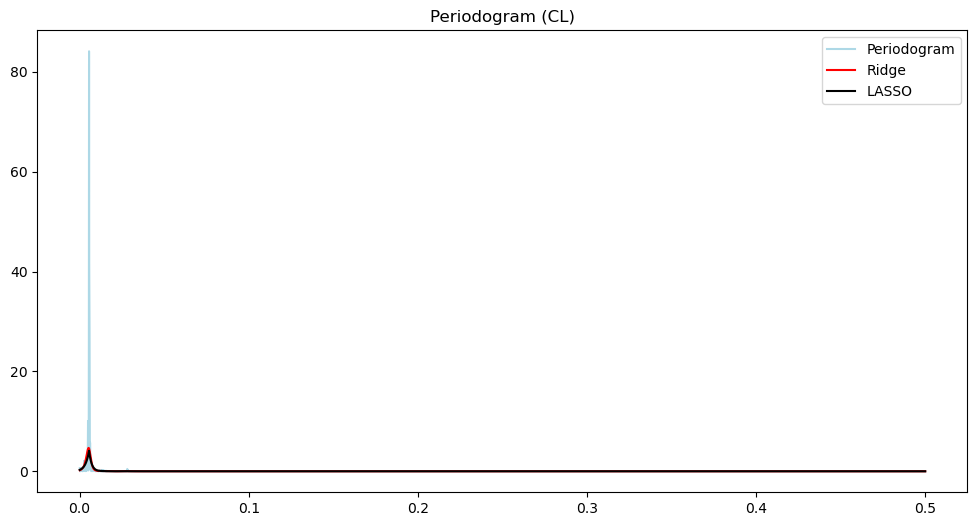

In [106]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, (pgram_cl), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Periodogram (CL)')
plt.plot(freqs, (pgram_mean_ridge_cl), color = 'red', label = 'Ridge')
plt.plot(freqs, (pgram_mean_lasso_cl), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

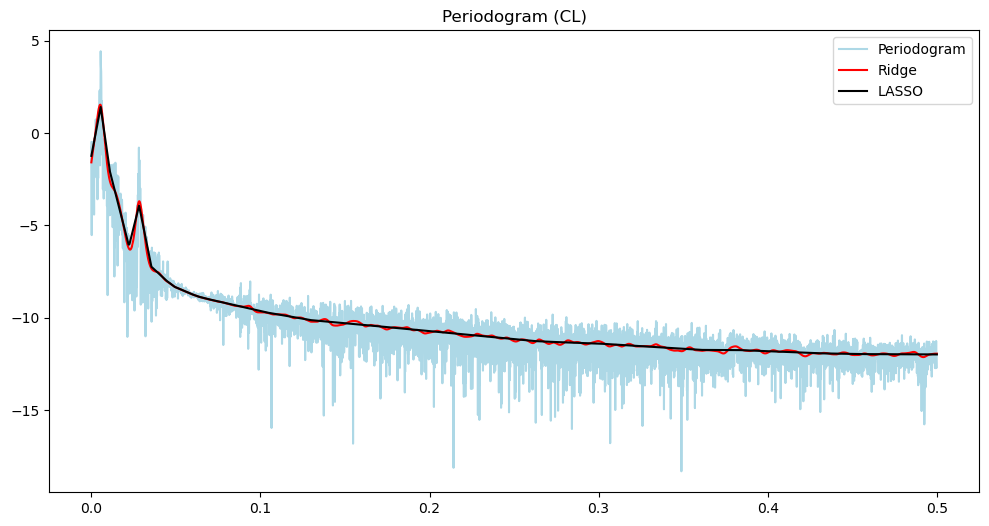

In [107]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_cl), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Periodogram (CL)')
plt.plot(freqs, np.log(pgram_mean_ridge_cl), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_cl), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

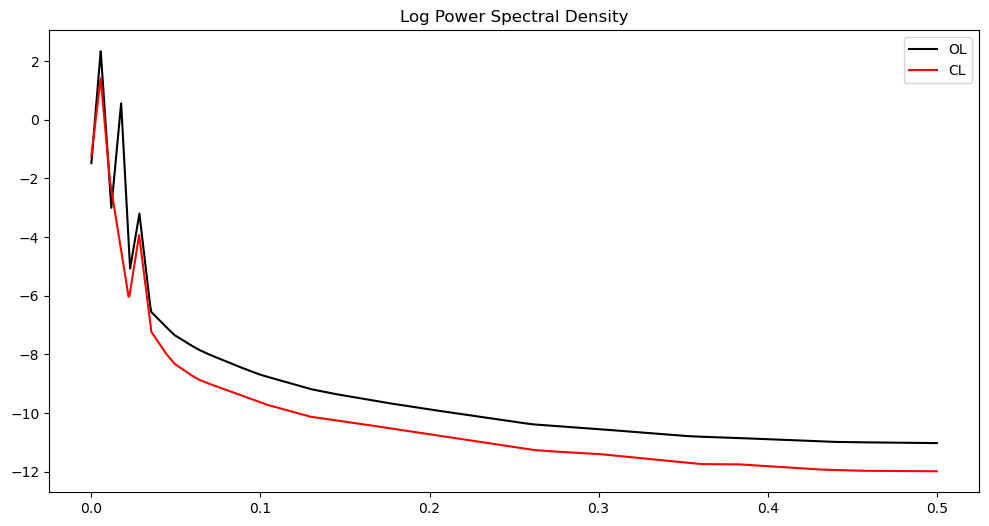

In [108]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_mean_lasso_ol), color = 'black', label = 'OL')
plt.plot(freqs, np.log(pgram_mean_lasso_cl), color = 'red', label = 'CL')
plt.legend()
plt.title('Log Power Spectral Density')
plt.show()

There are three loops on the open loop spectrum and two on the closed loop spectrum. The control system reduces the overall power of the vibrations and gets rid of one harmonic component. In other words, the control system not only reduces the vibration but also brings it closer to a sinusoid. 

The main point is that the differences between the two time series is much better summarized using their power spectra, compared to the raw data. 

### Application Four: EEG Motor Movement Dataset

The following dataset was downloaded from https://physionet.org/content/eegmmidb/1.0.0/. The specific dataset details are here: https://physionet.org/content/eegmmidb/1.0.0/. The dataset consists of over 1500 one and two minute (64 channel) EEG recordings, obtained from 109 volunteers. We will pick data for just one subject (volunteer) and one of the EEG channels, and compare the data for eyes open vs eyes closed. A basic finding of cognitive neuroscience is that the power of occipital alpha-band (~10 Hz) brain waves is increased when peoples' eyes are closed, rather than open (see, for example, the paper titled "Occipital alpha-band brain waves when the eyes are closed are shaped by ongoing visual processes" by Hohaia et al 2022). 

The mne python library is necessary for loading the data file. 

In [3]:
import mne

For each individual subject (here we are using the data for the first subject), there are 64 time series datasets for "open-eyes" and again 64 time series datasets for "closed-eyes". These 64 datasets correspond to the 64 channels which are different electrodes recording brain activity. We pick one of the channels, and compare the "open-eyes" and "closed-eyes" data. 

Extracting EDF parameters from /Users/aditya/Dropbox/Berkeley Teaching/153-248 Spring 2025/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


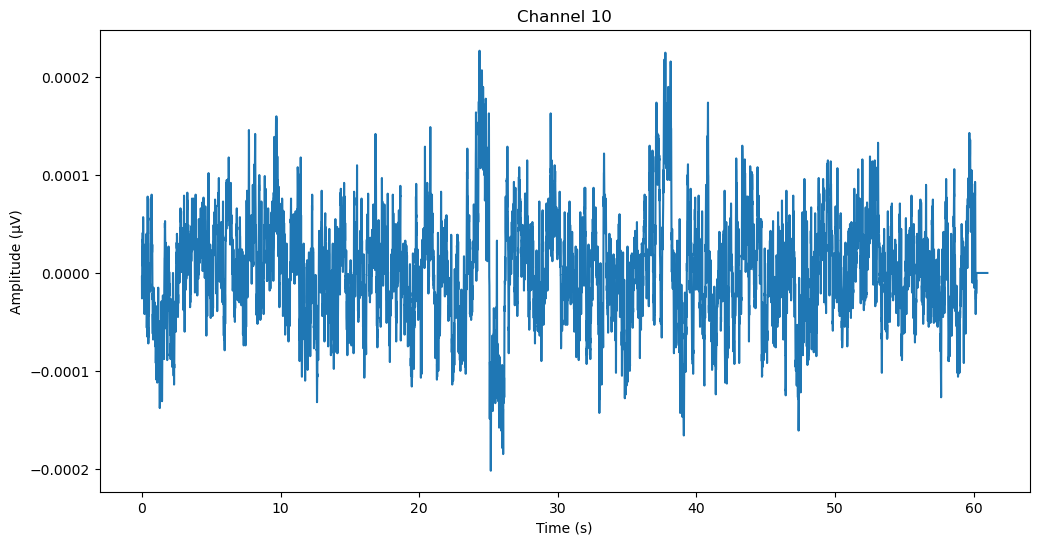

In [4]:
raw_1 = mne.io.read_raw_edf('S001R01.edf', preload = True)
print(raw_1.info)
data_1, times_1 = raw_1[:]

ch_index = 10  # pick a channel 
plt.figure(figsize=(12,6))
plt.plot(times_1, data_1[ch_index, :])
plt.title(f"Channel {ch_index}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

Extracting EDF parameters from /Users/aditya/Dropbox/Berkeley Teaching/153-248 Spring 2025/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


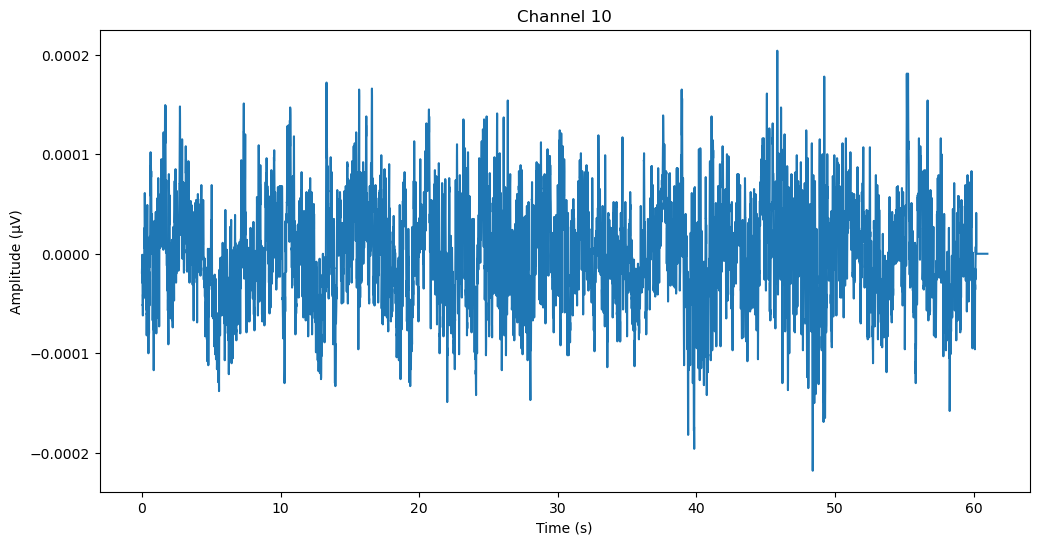

In [5]:
raw_2 = mne.io.read_raw_edf('S001R02.edf', preload = True)
print(raw_2.info)
data_2, times_2 = raw_2[:]

plt.figure(figsize=(12,6))
plt.plot(times_2, data_2[ch_index, :])
plt.title(f"Channel {ch_index}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()

In [7]:
#Let us check if the time series are equally spaced
print(np.diff(times_1))
print(np.diff(times_2))
#Let us check if the lengths of the two time series ('open eyes' and 'closed eyes') are the same
print(len(times_1))
print(len(times_2))

[0.00625 0.00625 0.00625 ... 0.00625 0.00625 0.00625]
[0.00625 0.00625 0.00625 ... 0.00625 0.00625 0.00625]
9760
9760


In [126]:
y_o = data_1[ch_index, :]
y_c = data_2[ch_index, :]

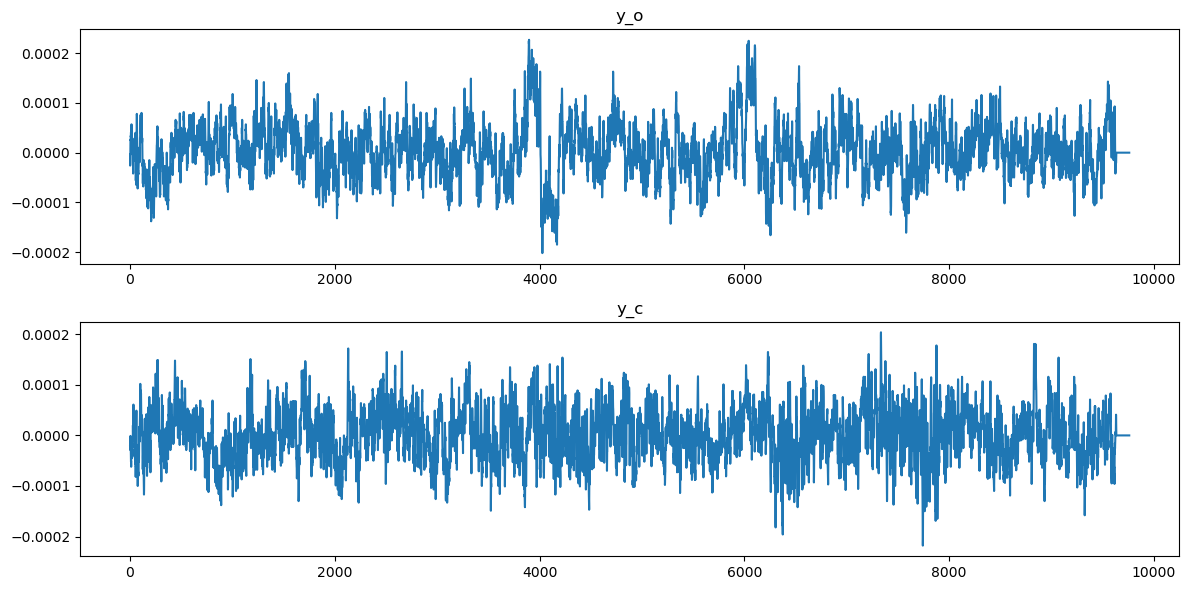

In [127]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))

axes[0].plot(y_o)
axes[0].set_title('y_o')

axes[1].plot(y_c)
axes[1].set_title('y_c')

plt.tight_layout()
plt.show()

In [128]:
n = len(y_o)
freqs, pgram_o = periodogram(y_o)
alpha_opt_ridge_o, freq = spectrum_estimator_ridge(y_o, 1000000)
pgram_mean_ridge_o = (2/n)*(np.exp(2*alpha_opt_ridge_o))
alpha_opt_lasso_o, freq = spectrum_estimator_lasso(y_o, 1000)
pgram_mean_lasso_o = (2/n)*(np.exp(2*alpha_opt_lasso_o))

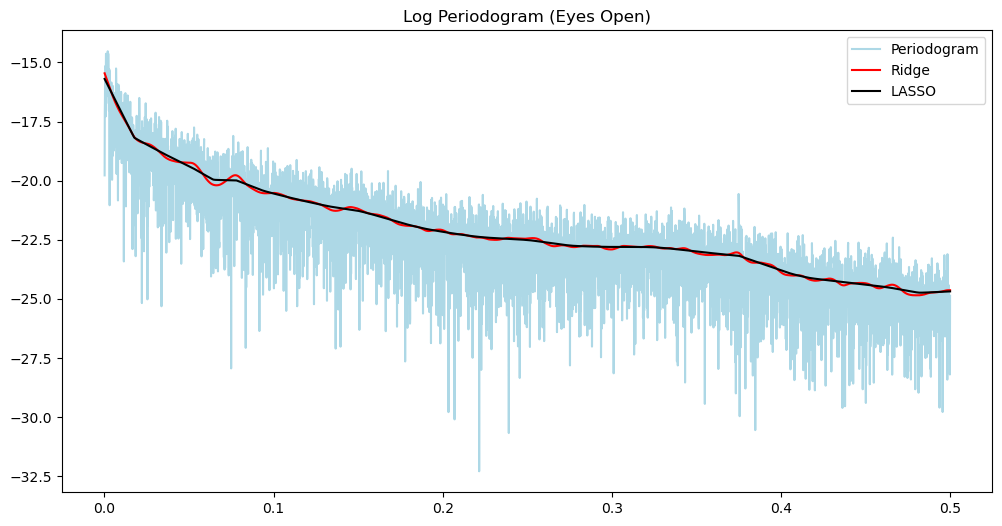

In [129]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_o), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Log Periodogram (Eyes Open)')
plt.plot(freqs, np.log(pgram_mean_ridge_o), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_o), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

In [130]:
n = len(y_c)
freqs, pgram_c = periodogram(y_c)
alpha_opt_ridge_c, freq = spectrum_estimator_ridge(y_c, 1000000)
pgram_mean_ridge_c = (2/n)*(np.exp(2*alpha_opt_ridge_c))
alpha_opt_lasso_c, freq = spectrum_estimator_lasso(y_c, 1000)
pgram_mean_lasso_c = (2/n)*(np.exp(2*alpha_opt_lasso_c))

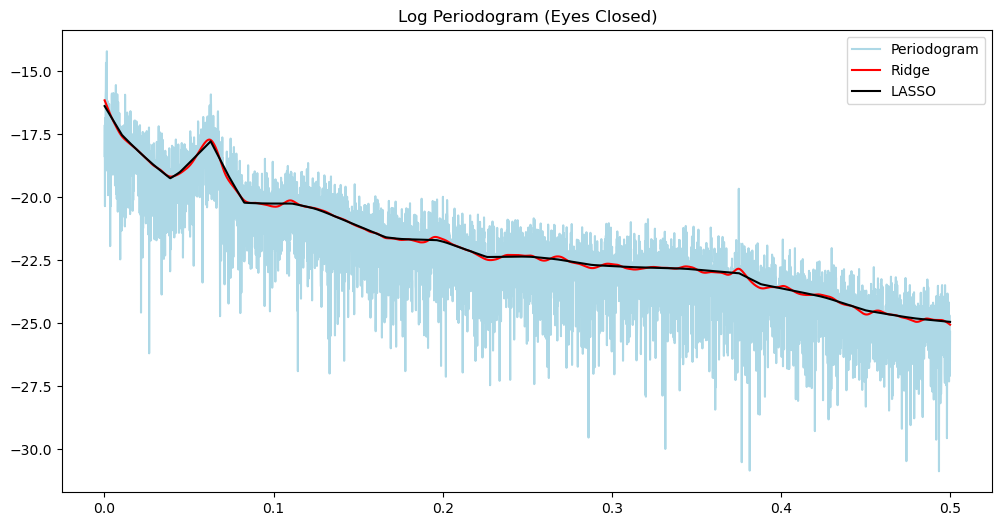

In [131]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_c), color = 'lightblue', label = 'Periodogram')
#plt.plot(freqs, np.log(pgram_cl), color = 'None', label = 'Periodogram')
plt.title('Log Periodogram (Eyes Closed)')
plt.plot(freqs, np.log(pgram_mean_ridge_c), color = 'red', label = 'Ridge')
plt.plot(freqs, np.log(pgram_mean_lasso_c), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

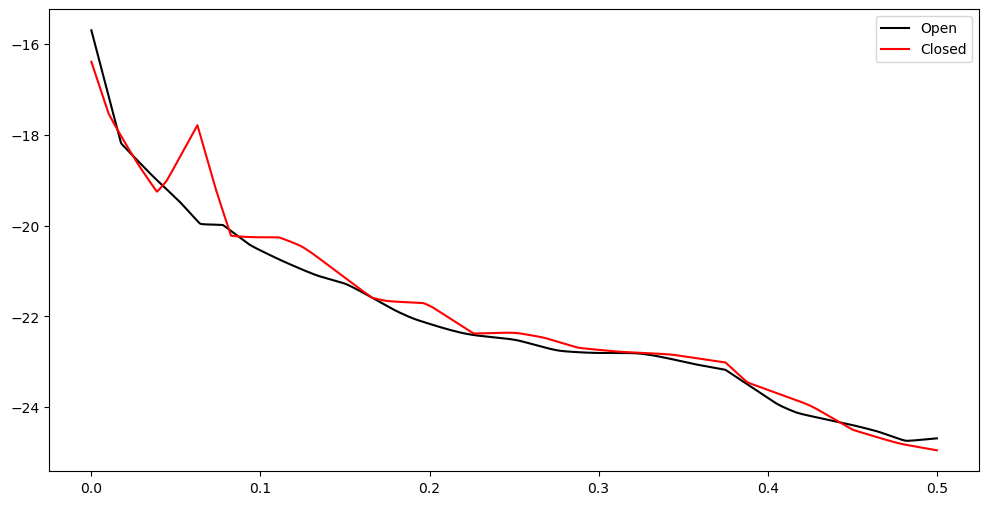

In [132]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram_mean_lasso_o), color = 'black', label = 'Open')
plt.plot(freqs, np.log(pgram_mean_lasso_c), color = 'red', label = 'Closed')
plt.legend()
plt.show()

In [133]:
sampling_rate = raw_1.info['sfreq']
print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 160.0 Hz


In [134]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(pgram_mean_lasso_c))
print(peaks/n)

[0.06270492 0.1079918  0.24518443]


The peak corresponds to the frequency $0.06270492$. To conver the frequency to Hertz, we multiply it by the sampling rate. 

In [135]:
(peaks[0]/n) * sampling_rate

10.032786885245901

So the differences between the two power spectra is mainly at frequency 10.0328 Hz. This is very close to the 10Hz Alpha rhythm which apparently exists when eyes are closed as opposed to eyes being open (see, for example, the first sentence in this paper "Occipital alpha-band brain waves when the eyes are closed are shaped by ongoing visual processes" by Hohaia et al 2022)